In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pyproj import Proj
import cartopy.feature as cfeature
from pathlib import Path
import cmaqsatproc as csp
import pyrsig
import pycno
import glob

/home/jkumm/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Root directory
root_dir = Path("/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/eval/POST/")

# Run configurations
runs = {
    "BASE" : ("EMBER_BASE", "NOASSIM"),
    # "ASSIM" : ("EMBER_ASSIM", "ASSIM"),
    # "SCALE" : ("EMBER_SCALE_FINAL", "SCALE8_FINAL"),
    "SCALE_ASSIM" : ("EMBER_SCALE_ASSIM_FINAL_202506", "ASSIM8_FINAL")

}
months = ["05", "06", "07", "08", "09"]  # May - September 2023
variables = ["NO2_DAILYAV", "O3_MDA8"]

In [3]:
# Define the file paths for BASE and ASSIM runs
base_files = glob.glob('/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/eval/POST/EMBER_BASE/*/AQS_Daily_O3_EMBER_BASE.csv')
base_files = [f for f in base_files if any(month in f for month in ['202305', '202306', '202307', '202308', '202309'])]
scale_assim_files = glob.glob('/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/eval/POST/EMBER_SCALE_ASSIM_FINAL_202506/*/AQS_Daily_O3_EMBER_SCALE_ASSIM_FINAL_202506.csv')

In [4]:
def preprocess(ds):
    """
    Preprocess each dataset to exclude the last timestep.
    """
    return ds.isel(TSTEP=slice(None, -1))

def load_data():
    datasets = {}
    for run_name, (run_dir, run_id) in runs.items():
        file_list = [root_dir / run_dir / 
                     f"HR2DAY_LST_ACONC_CMAQv54_cb6r5_ae7_aq.36US3.35.{run_id}_2023{month}.nc"
                     for month in months]
        
        # Use preprocess to exclude the last timestep from each file
        ds = xr.open_mfdataset(file_list, combine='nested', concat_dim='TSTEP', 
                               data_vars='minimal', coords='minimal', engine='netcdf4',
                               preprocess=preprocess)
        
        # Update TSTEP to reflect the correct dates
        total_days = len(ds['TSTEP'])
        ds['TSTEP'] = pd.date_range('2023-05-01', periods=total_days, freq='D')
        
        datasets[run_name] = ds
    return datasets

full_datasets = load_data()

In [5]:
full_aqs_table = []

# Loop through each month's files
for base_file, scale_assim_file in zip(base_files, scale_assim_files):

    # Read the data
    bdf = pd.read_csv(base_file, skiprows=5, na_values=[-999])
    cdf = pd.read_csv(scale_assim_file, skiprows=5, na_values=[-999])
    
    # Rename 'O3_8hrmax_9cell_mod' column in cdf to 'O3_8hrmax_9cell_mod_scale_assim' for clarity
    cdf = cdf.rename(columns={'O3_8hrmax_mod': 'O3_8hrmax_mod_scale_assim'})
    
    # Reset indices to ensure alignment
    bdf = bdf.reset_index()
    cdf = cdf.reset_index()

    # cdf = cdf.rename(columns={'O3_8hrmax_9cell_mod': 'O3_8hrmax_9cell_mod_scale_assim'})

    # Drop rows with NaN values in the relevant columns
    aqs_table = bdf[['SiteId', 'State', 'County', 'Latitude', 'Longitude', 'Column', 'Row', 'Time On', 'O3_8hrmax_ob', 'O3_8hrmax_mod']]
    aqs_table = aqs_table.join(cdf[['O3_8hrmax_mod_scale_assim']]).dropna()
    # Debug: Print intermediate data
    # print(valid_data.head())

    # # Observed and modeled O3_8hrmax_9cell for BASE and ASSIM
    # mda8o3_obs = aqs_table['O3_8hrmax_9cell_ob']
    # mda8o3_base = aqs_table['O3_8hrmax_9cell_mod']
    # mda8o3_scale_assim = aqs_table['O3_8hrmax_9cell_mod_scale_assim']

    # Append to the full AQS table
    full_aqs_table.append(aqs_table)

full_aqs_table = pd.concat(full_aqs_table, ignore_index=True)
full_aqs_table['Time On'] = pd.to_datetime(full_aqs_table['Time On'], format='%m/%d/%Y %H:%M')
full_aqs_table = full_aqs_table.sort_values(by=['Time On', 'SiteId']).reset_index(drop=True)

In [6]:
full_aqs_table

SiteId    State      County  Latitude  Longitude  Column  Row  \
0        10030010  Alabama     Baldwin    30.497    -87.880     107   49   
1        10499991  Alabama      DeKalb    34.289    -85.970     111   62   
2        10510004  Alabama      Elmore    32.536    -86.255     110   56   
3        10550011  Alabama      Etowah    33.904    -86.054     110   60   
4        10730023  Alabama   Jefferson    33.553    -86.815     109   59   
...           ...      ...         ...       ...        ...     ...  ...   
181132  560359991  Wyoming    Sublette    42.929   -109.790      54   89   
181133  560370200  Wyoming  Sweetwater    41.678   -108.020      57   84   
181134  560370300  Wyoming  Sweetwater    41.751   -109.790      53   85   
181135  560390008  Wyoming       Teton    43.671   -110.600      52   91   
181136  560450003  Wyoming      Weston    43.873   -104.190      67   90   

          Time On  O3_8hrmax_ob  O3_8hrmax_mod  O3_8hrmax_mod_scale_assim  
0      2023-05-01        56.875         62.114                     61.011  
1      2023-05-01        50.375         51.497                     52.811  
2      2023-05-01        48.625         47.767                     48.266  
3      2023-05-01        48.625         50.572                     51.680  
4      2023-05-01        50.125         49.452                     50.309  
...           ...           ...            ...                        ...  
181132 2023-09-29        46.625         46.963                     46.256  
181133 2023-09-29        45.375         51.849                     50.685  
181134 2023-09-29        49.250         52.825                     51.319  
181135 2023-09-29        41.875         44.618                     44.567  
181136 2023-09-29        39.625         44.653                     44.129  

[181137 rows x 11 columns]

In [7]:
ne_dates = ['2023-06-03', '2023-06-04', '2023-06-05', '2023-06-06', '2023-06-07', '2023-06-08', '2023-06-09']
mw_dates = ['2023-07-12', '2023-07-13', '2023-07-14', '2023-07-15', '2023-07-16', '2023-07-17', '2023-07-18']

In [8]:
o3_base_mod_ne = [48.0774, 46.6934, 51.1256, 62.3779, 62.0862, 56.5492, 44.8414]
o3_scale_assim_mod_ne = [47.7672, 45.1704, 47.7011, 57.3869, 59.1857, 55.6325, 43.7125]
o3_obs_ne = [47.1248, 41.8334, 45.2526, 54.7219, 51.7995, 46.6823, 38.2963]

In [9]:
o3_base_mod_mw = [49.5242, 47.9762, 52.3969, 51, 57.5677, 45.7989, 44.4101]
o3_scale_assim_mod_mw = [47.2554, 46.842, 50.9742, 49.0296, 53.5817, 44.5688, 43.1434]
o3_obs_mw = [45.9174, 47.2532, 53.1993, 45.8427, 48.5881, 43.6402, 42.927]

In [10]:
std_obs_mw = [9.8, 6.32, 6.48, 8.11, 7.61, 9.81, 7.74]
std_mod_mw = [7.41, 5.23, 6.11, 6.83, 10.7, 11.3, 6.98]

In [11]:
std_obs_ne = [13.3, 7.99, 4.43, 7.01, 9.82, 12, 8.16]
std_mod_ne = [6.7, 4.56, 5.29, 5.46, 8.59, 11.5, 8.05]

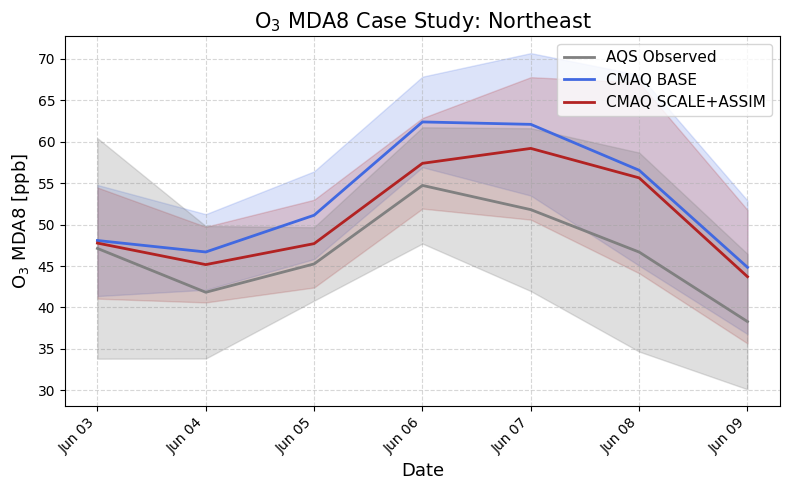

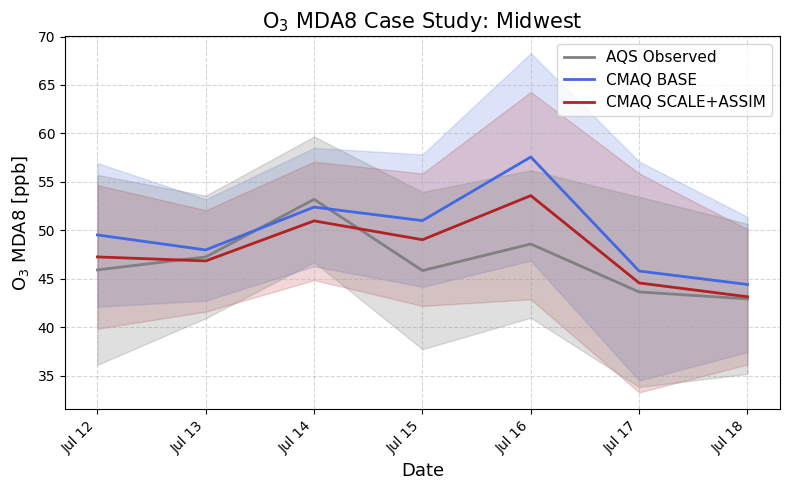

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_o3_case(dates, obs, base, scale_assim, std_obs, std_base, std_scale_assim, region_label):
    """
    Plot O3 MDA8 time series with uncertainty bands for obs, base, and scale_assim.
    """
    dates = pd.to_datetime(dates)
    fig, ax = plt.subplots(figsize=(8, 5))

    # Plot observed
    ax.plot(dates, obs, color='gray', label='AQS Observed', linewidth=2, zorder=3)
    ax.fill_between(dates, np.array(obs)-np.array(std_obs), np.array(obs)+np.array(std_obs),
                    color='gray', alpha=0.25, zorder=2)

    # Plot BASE model
    ax.plot(dates, base, color='royalblue', label='CMAQ BASE', linewidth=2, zorder=4)
    ax.fill_between(dates, np.array(base)-np.array(std_base), np.array(base)+np.array(std_base),
                    color='royalblue', alpha=0.18, zorder=1)

    # Plot SCALE+ASSIM model
    ax.plot(dates, scale_assim, color='firebrick', label='CMAQ SCALE+ASSIM', linewidth=2, zorder=5)
    ax.fill_between(dates, np.array(scale_assim)-np.array(std_scale_assim), np.array(scale_assim)+np.array(std_scale_assim),
                    color='firebrick', alpha=0.18, zorder=1)

    # Formatting
    ax.set_ylabel('O$_3$ MDA8 [ppb]', fontsize=13)
    ax.set_xlabel('Date', fontsize=13)
    ax.set_title(f'O$_3$ MDA8 Case Study: {region_label}', fontsize=15)
    ax.legend(frameon=True, fontsize=11)
    ax.grid(True, which='both', linestyle='--', alpha=0.5)
    ax.set_xticks(dates)
    ax.set_xticklabels([d.strftime('%b %d') for d in dates], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage for NE:
plot_o3_case(
    dates=ne_dates,
    obs=o3_obs_ne,
    base=o3_base_mod_ne,
    scale_assim=o3_scale_assim_mod_ne,
    std_obs=std_obs_ne,
    std_base=std_mod_ne,
    std_scale_assim=std_mod_ne,  # If you have separate std for scale_assim, use it here
    region_label='Northeast'
)

# Example usage for MW:
plot_o3_case(
    dates=mw_dates,
    obs=o3_obs_mw,
    base=o3_base_mod_mw,
    scale_assim=o3_scale_assim_mod_mw,
    std_obs=std_obs_mw,
    std_base=std_mod_mw,
    std_scale_assim=std_mod_mw,  # If you have separate std for scale_assim, use it here
    region_label='Midwest'
)

In [13]:
%pip install plotnine

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_3205785/1828422145.py:50: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


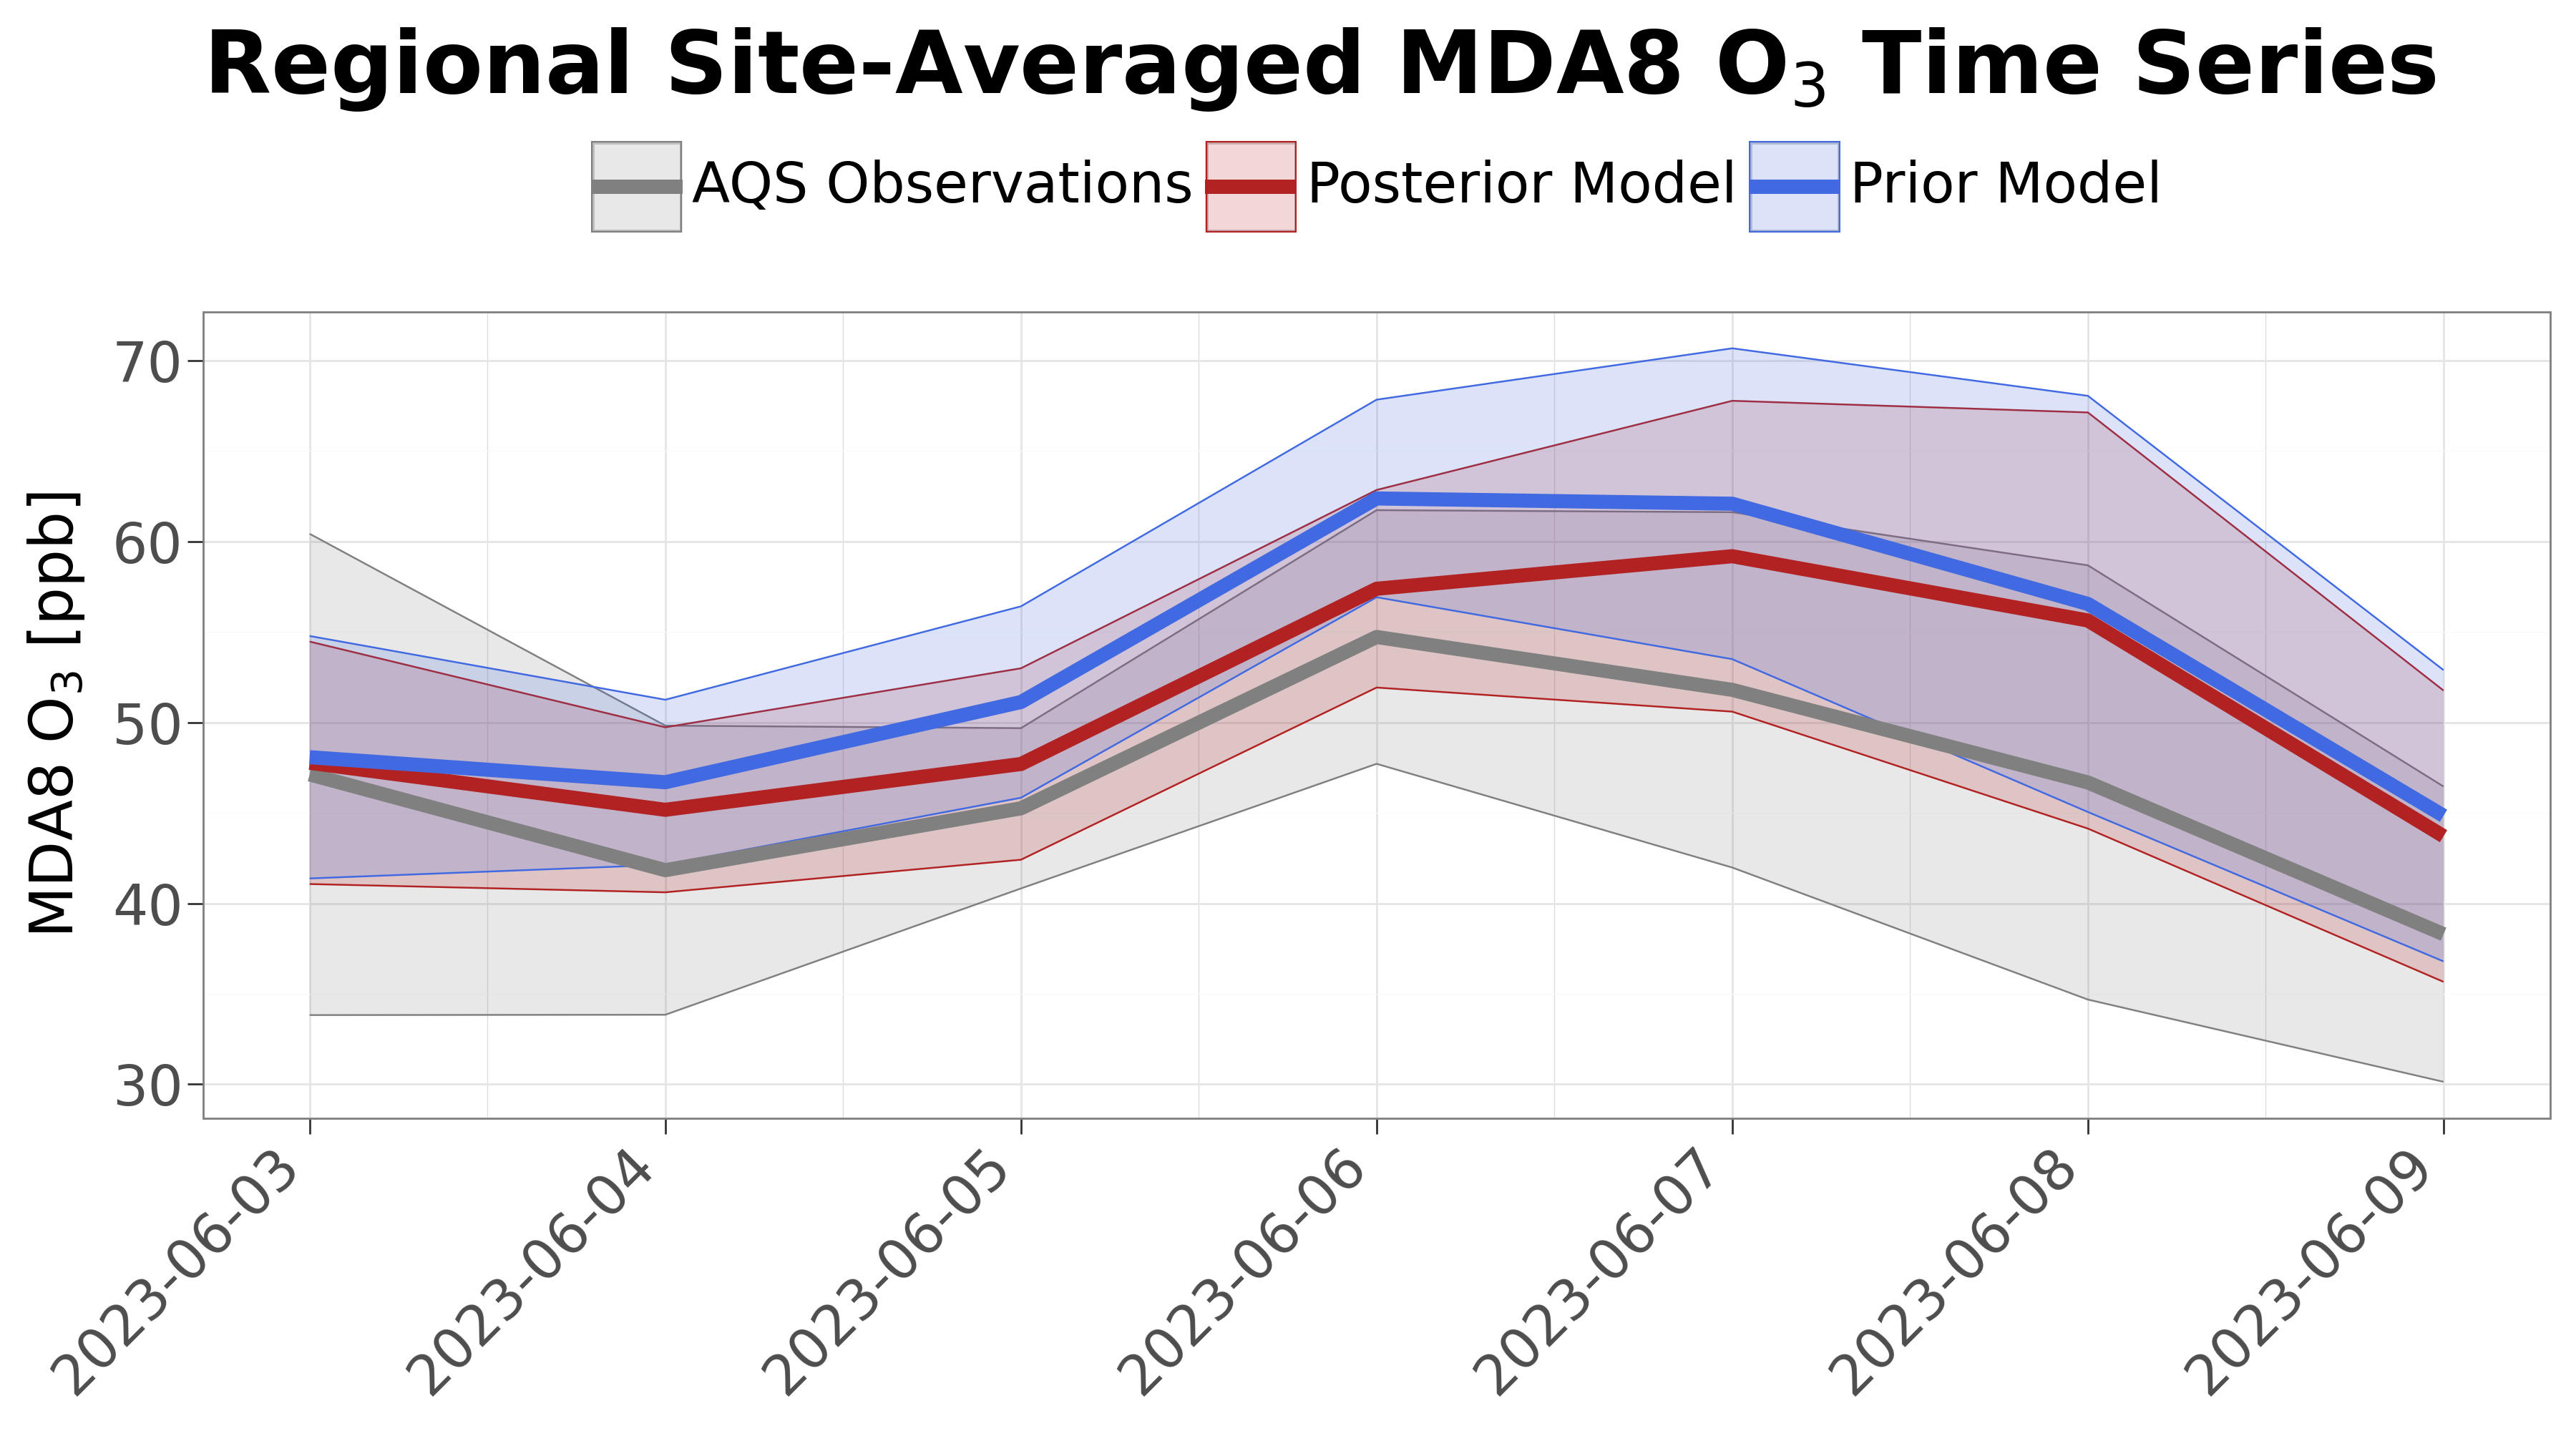

/tmp/ipykernel_3205785/1828422145.py:50: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


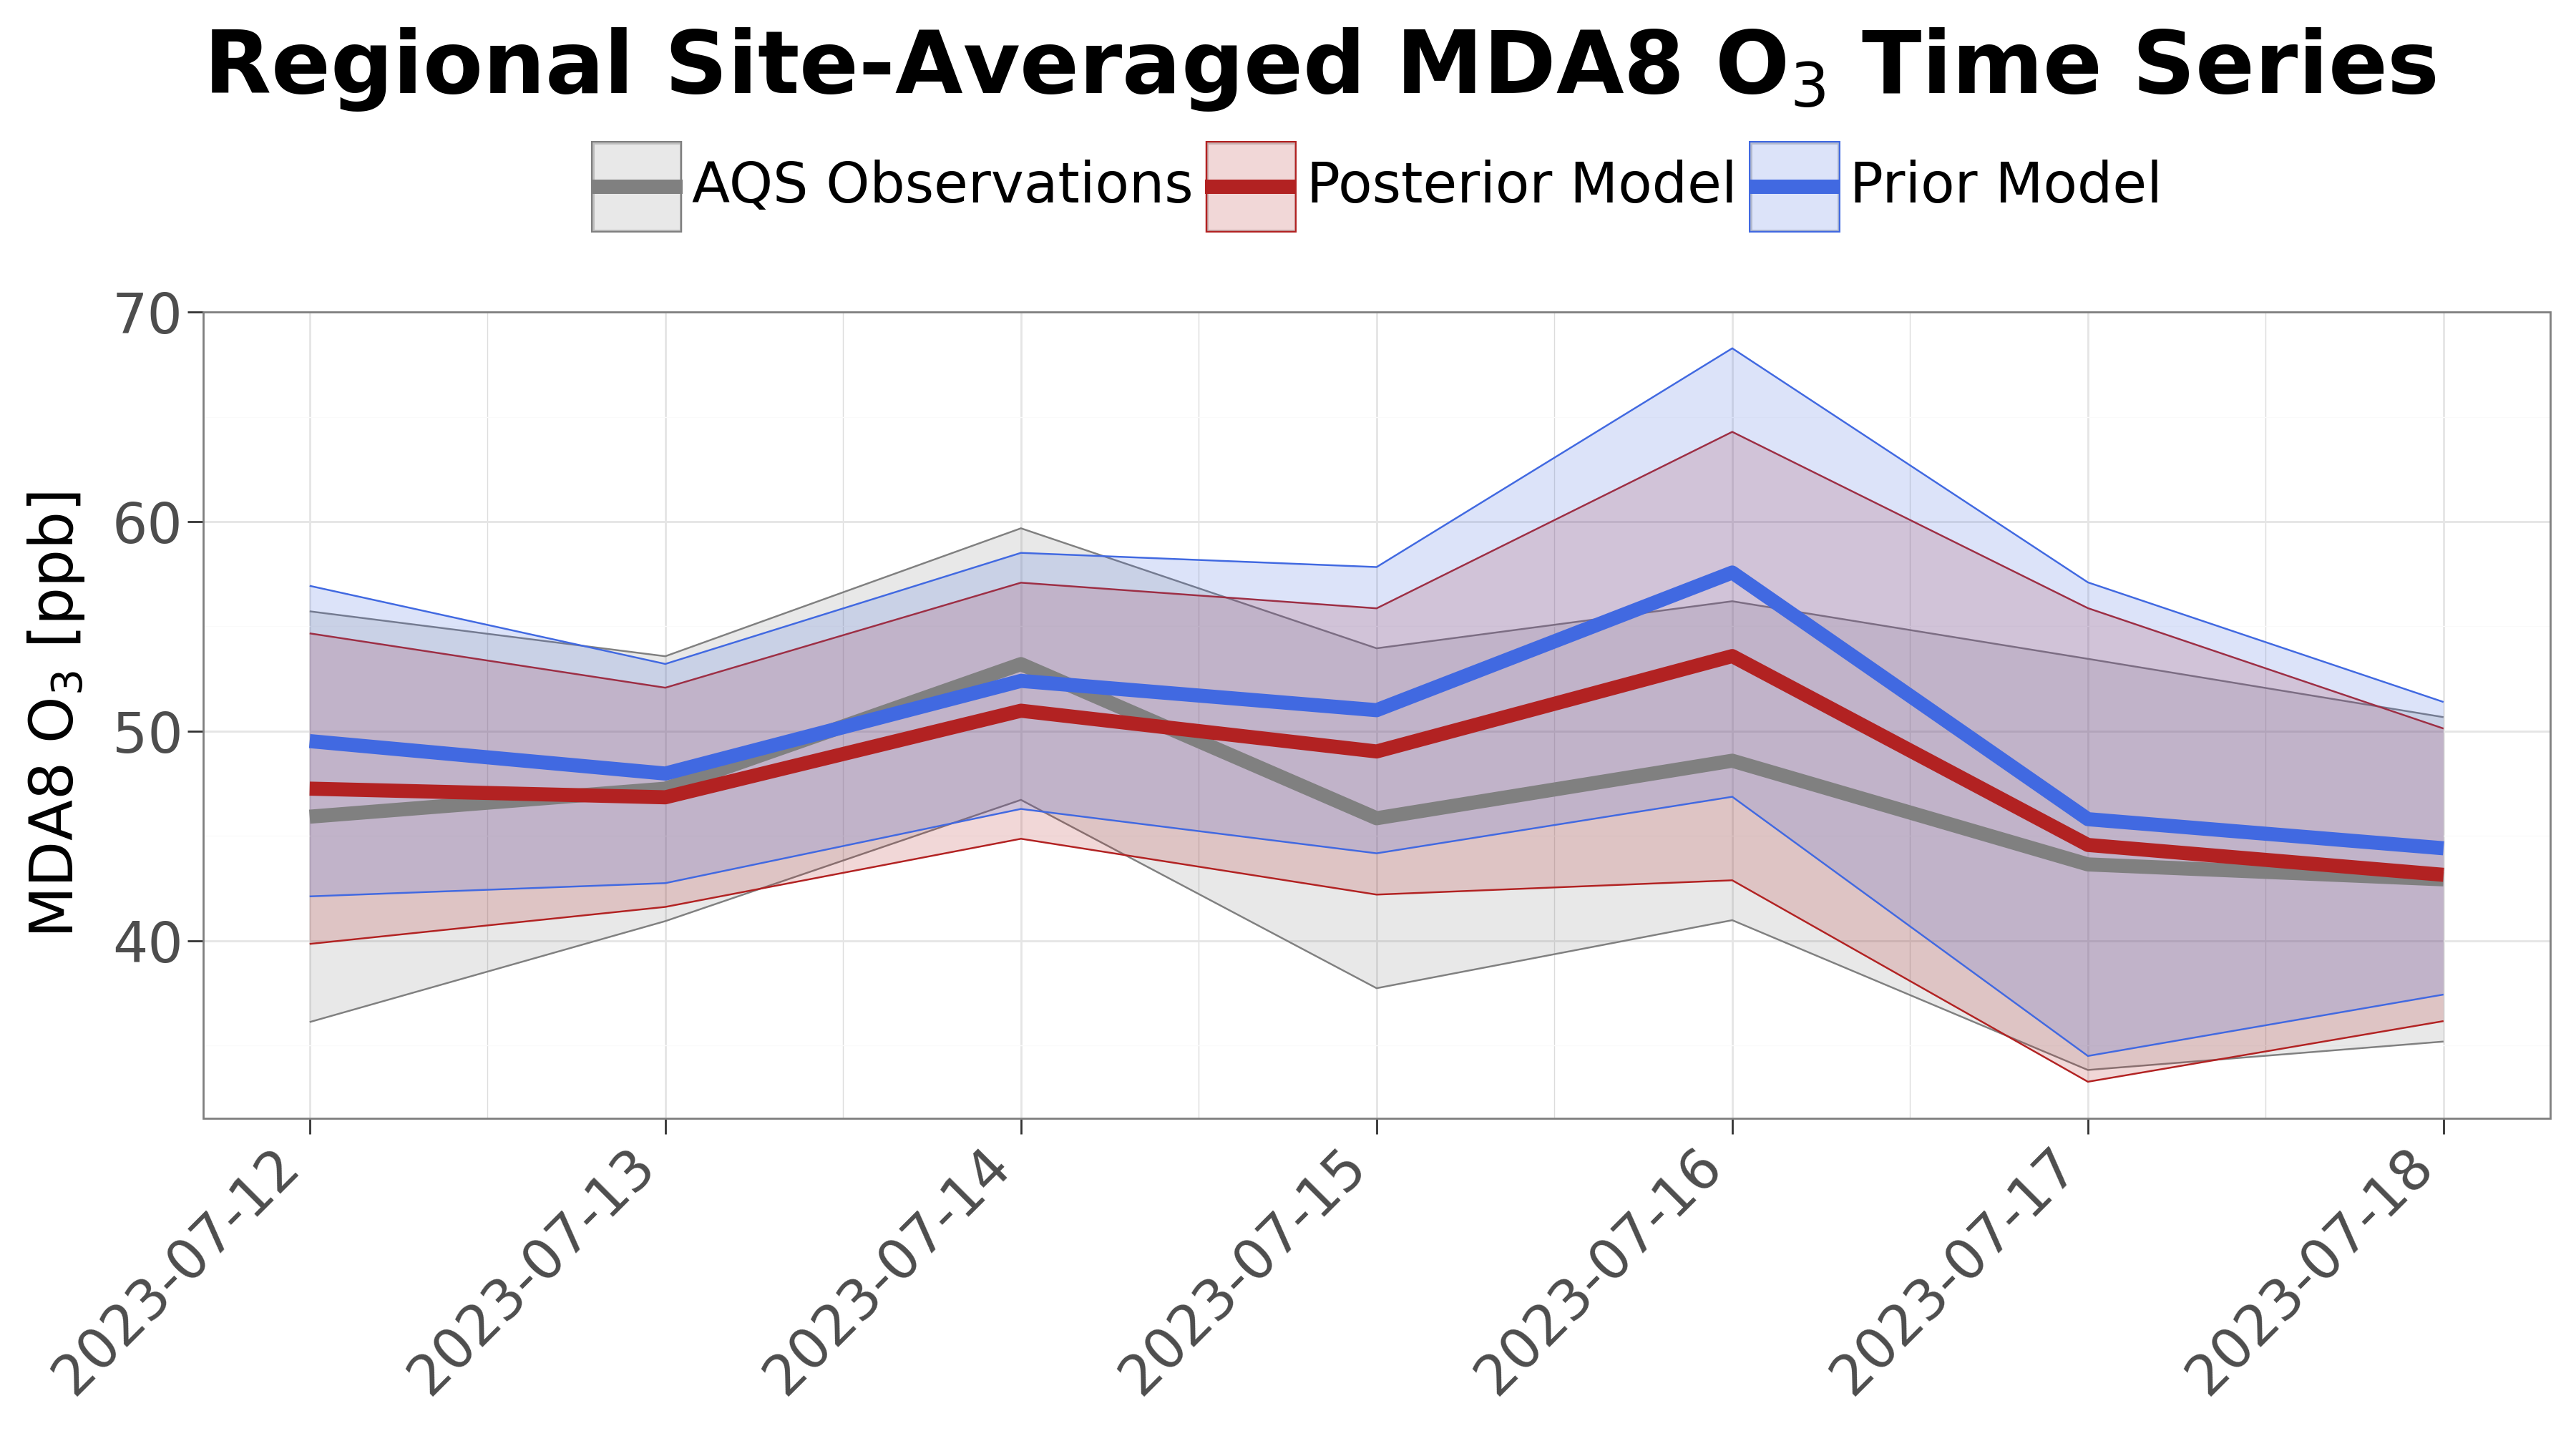

In [14]:
import pandas as pd
import numpy as np
from plotnine import *

def plot_o3_case_ggplot(dates, obs, base, scale_assim, std_obs, std_base, std_scale_assim, region_label):
    # Prepare tidy DataFrame
    n = len(dates)
    dt_dates = pd.to_datetime(dates)
    df = pd.DataFrame({
        'Date': np.tile(dt_dates, 3),
        'O3_MDA8': obs + base + scale_assim,
        'Std': std_obs + std_base + std_scale_assim,
        'Type': (['AQS Observations'] * n) + (['Prior Model'] * n) + (['Posterior Model'] * n)
    })
    df['ymin'] = df['O3_MDA8'] - df['Std']
    df['ymax'] = df['O3_MDA8'] + df['Std']

    # Color mapping for clarity
    color_map = {'AQS Observations': 'gray', 'Prior Model': 'royalblue', 'Posterior Model': 'firebrick'}

    p = (
        ggplot(df, aes('Date', 'O3_MDA8', color='Type', fill='Type'))
        + geom_ribbon(aes(ymin='ymin', ymax='ymax'), alpha=0.18)
        + geom_line(size=4)
        + scale_color_manual(values=color_map)
        + scale_fill_manual(values=color_map)
        + scale_x_datetime(
            breaks=dt_dates,
            labels=[d.strftime('%Y-%m-%d') for d in dt_dates]
        )
        + labs(
            title=f'Regional Site-Averaged MDA8 O$_3$ Time Series',
            x='',
            y='MDA8 O$_3$ [ppb]'
        )
        + theme_bw(base_size=32)
        + theme(
            axis_text_x=element_text(size=28, rotation=45, ha='right'),
            axis_text_y=element_text(size=28),
            axis_title_x=element_text(size=30),
            axis_title_y=element_text(size=30),
            legend_title=element_blank(),
            legend_text=element_text(size=28),
            legend_position='top',
            plot_title=element_text(size=44, weight='bold', ha='left'),
            figure_size=(18, 10),
            panel_grid_minor_x=element_line(color='gainsboro', size=0.5)
        )
    )
    print(p)

# Example usage for NE:
plot_o3_case_ggplot(
    dates=ne_dates,
    obs=o3_obs_ne,
    base=o3_base_mod_ne,
    scale_assim=o3_scale_assim_mod_ne,
    std_obs=std_obs_ne,
    std_base=std_mod_ne,
    std_scale_assim=std_mod_ne,  # If you have separate std for scale_assim, use it here
    region_label='Northeast'
)

# Example usage for MW:
plot_o3_case_ggplot(
    dates=mw_dates,
    obs=o3_obs_mw,
    base=o3_base_mod_mw,
    scale_assim=o3_scale_assim_mod_mw,
    std_obs=std_obs_mw,
    std_base=std_mod_mw,
    std_scale_assim=std_mod_mw,  # If you have separate std for scale_assim, use it here
    region_label='Midwest'
)

In [15]:
import pandas as pd

# Import Northeast and Midwest bias stats CSVs, skipping the first two rows
bias_stats_ne = pd.read_csv('/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/manuscript/results/bias_stats_northeast.csv', skiprows=2)
bias_stats_mw = pd.read_csv('/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/manuscript/results/bias_stats_midwest.csv', skiprows=2)

# Preview the data
display(bias_stats_ne.head())
display(bias_stats_mw.head())

Site       Lat       Lon      Bias1      Bias2  Bias_Diff     Error1  \
0  711211  36.89117 -81.25423   4.451143   6.992000  -2.540857   4.451143   
1  731231  37.32320 -80.45720   1.655143   3.555000  -1.899857   1.655143   
2  731241  37.28342 -79.88452   3.515286   5.415143  -1.899857   3.515286   
3  731281  37.16550 -78.30690  10.283857  12.546857  -2.263000  10.283857   
4  731321  36.66525 -76.73078  12.116857  13.889143  -1.772286  12.116857   

      Error2  Error_Diff     Corr1     Corr2  Corr_Diff  
0   6.992000   -2.540857  0.795659  0.735069   0.060591  
1   3.555000   -1.899857  0.925473  0.906700   0.018773  
2   5.415143   -1.899857  0.877669  0.839300   0.038369  
3  12.546857   -2.263000  0.757131  0.696773   0.060358  
4  13.889143   -1.772286  0.654383  0.719663  -0.065280

Site        Lat       Lon     Bias1      Bias2  Bias_Diff    Error1  \
0  690891  37.238500 -94.42468 -3.916071  -3.255643   0.660429  3.916071   
1  690921  37.287665 -93.25215 -0.506786  -0.052929   0.453857  0.506786   
2  691061  36.911710 -87.32334  5.668571   7.383000  -1.714429  5.668571   
3  691081  36.708610 -86.56628  4.400286   6.901429  -2.501143  4.400286   
4  691151  36.608430 -83.73694  7.986429  10.577857  -2.591429  7.986429   

      Error2  Error_Diff     Corr1     Corr2  Corr_Diff  
0   3.255643    0.660429  0.442009  0.447538  -0.005529  
1   0.052929    0.453857  0.172543  0.022816   0.149728  
2   7.383000   -1.714429  0.826500  0.856119  -0.029620  
3   6.901429   -2.501143  0.947399  0.938174   0.009225  
4  10.577857   -2.591429  0.832534  0.855614  -0.023081

In [16]:
# !wget https://www2.census.gov/geo/tiger/TIGER2023/COUNTY/tl_2023_us_county.zip
# !unzip tl_2023_us_county.zip -d counties_shapefile

/home/jkumm/.local/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
/home/jkumm/.local/lib/python3.9/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.


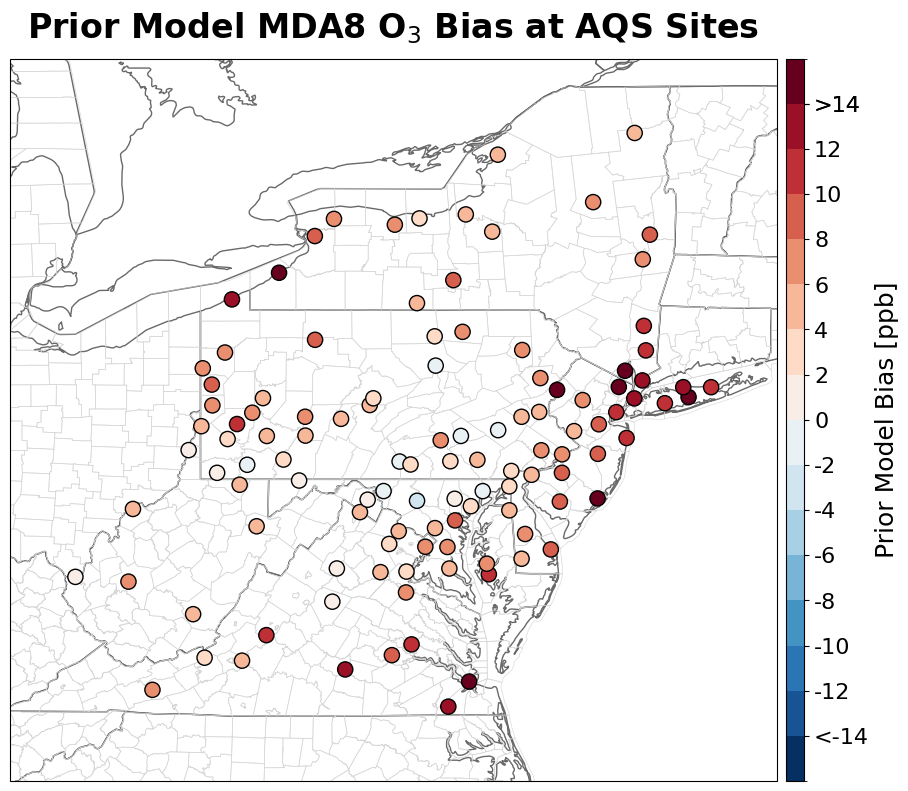

/home/jkumm/.local/lib/python3.9/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.


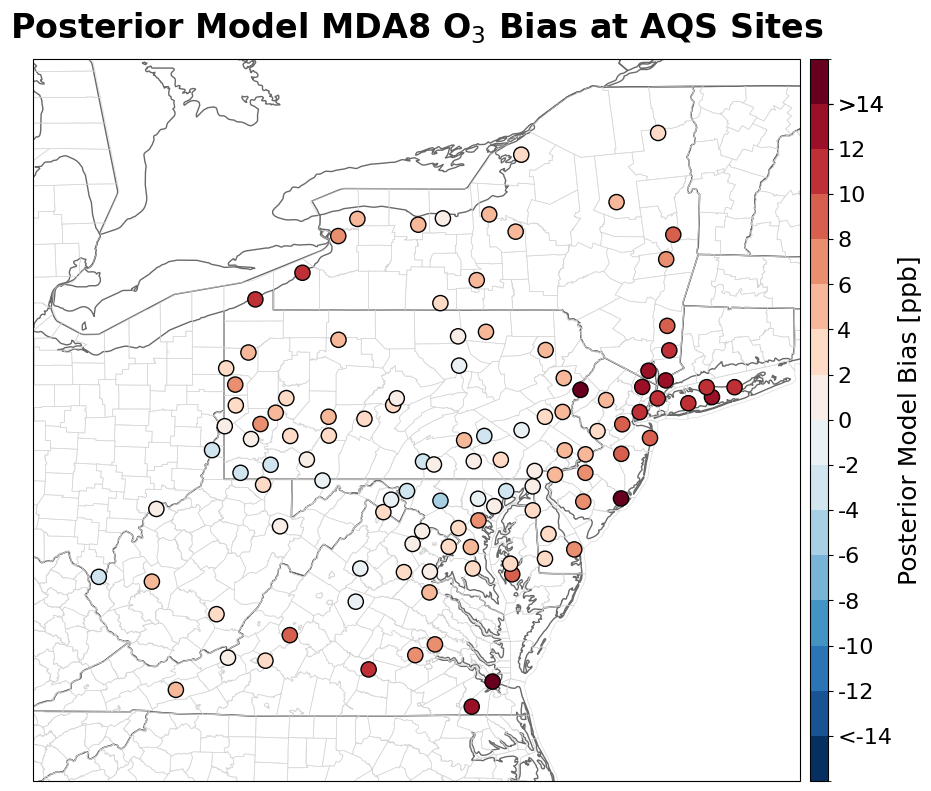

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.colors import BoundaryNorm

def plot_bias_map(
    df,
    counties_shapefile_path,
    region_extent=None,
    cmap='RdBu_r',
    title='Site Bias Map',
    use_posterior=False,
    save_label='prior_northeast'
):
    """
    Plot site locations colored by Bias on a map with state and county boundaries.
    Colorbar is centered at 0 and binned every 2 ppb from <-20 to >+20.
    Args:
        df: DataFrame with columns ['Lat', 'Lon', 'Bias2', 'Bias1']
        counties_shapefile_path: Path to US counties shapefile (.shp)
        region_extent: [lon_min, lon_max, lat_min, lat_max] or None for auto
        cmap: Colormap for Bias
        title: Plot title
        use_posterior: If True, plot Bias1 (Posterior Model); else Bias2 (Prior Model)
    """
    # Choose which bias to plot
    bias_col = 'Bias1' if use_posterior else 'Bias2'
    bias_label = 'Posterior Model' if use_posterior else 'Prior Model'

    # Define bins from -22 to 22 (so that <-20 and >20 are included), step 2
    # bins = np.arange(-22, 24, 2)
    bins = np.arange(-16, 18, 2)
    norm = BoundaryNorm(bins, ncolors=plt.get_cmap(cmap).N, clip=True)

    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set extent
    if region_extent:
        ax.set_extent(region_extent, crs=ccrs.PlateCarree())
    else:
        margin = 1
        ax.set_extent([
            df['Lon'].min()-margin, df['Lon'].max()+margin,
            df['Lat'].min()-margin, df['Lat'].max()+margin
        ], crs=ccrs.PlateCarree())

    # Add state boundaries
    ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='dimgray', linewidth=1, zorder=1)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='dimgray', linewidth=1, zorder=1)

    # Add all US counties
    counties = gpd.read_file(counties_shapefile_path)
    counties = counties.to_crs(epsg=4326)
    counties.boundary.plot(ax=ax, linewidth=0.5, edgecolor='lightgray', zorder=2, alpha=0.8)

    # Plot the sites
    sc = ax.scatter(
        df['Lon'], df['Lat'], c=df[bias_col], cmap=cmap, s=200, edgecolor='black',
        norm=norm, zorder=3
    )
    # Custom ticks/labels for colorbar
    cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.01, aspect=40, boundaries=bins, ticks=bins)
    cbar.set_label(f'{bias_label} Bias [ppb]', fontsize=18)
    cbar.ax.tick_params(labelsize=16)
    tick_labels = [f"<{bins[1]}"] + [str(int(b)) for b in bins[2:-1]] + [f">{bins[-2]}"]
    cbar.set_ticks([bins[1]] + list(bins[2:-1]) + [bins[-2]])
    cbar.set_ticklabels(tick_labels)

    ax.set_title(title, fontsize=24, weight='bold', pad=15)
    ax.set_xlabel('Longitude', fontsize=16)
    ax.set_ylabel('Latitude', fontsize=16)
    ax.tick_params(labelsize=14)
    plt.tight_layout()
    plt.savefig(f"./final_plots/{save_label}_bias.png", dpi=600, bbox_inches="tight", transparent=False)
    plt.show()

# Example usage:
plot_bias_map(bias_stats_ne, 'counties_shapefile/tl_2023_us_county.shp', title='Prior Model MDA8 O$_3$ Bias at AQS Sites', save_label='northeast_prior')
plot_bias_map(bias_stats_ne, 'counties_shapefile/tl_2023_us_county.shp', title='Posterior Model MDA8 O$_3$ Bias at AQS Sites', use_posterior=True, save_label='northeast_post')

/home/jkumm/.local/lib/python3.9/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.


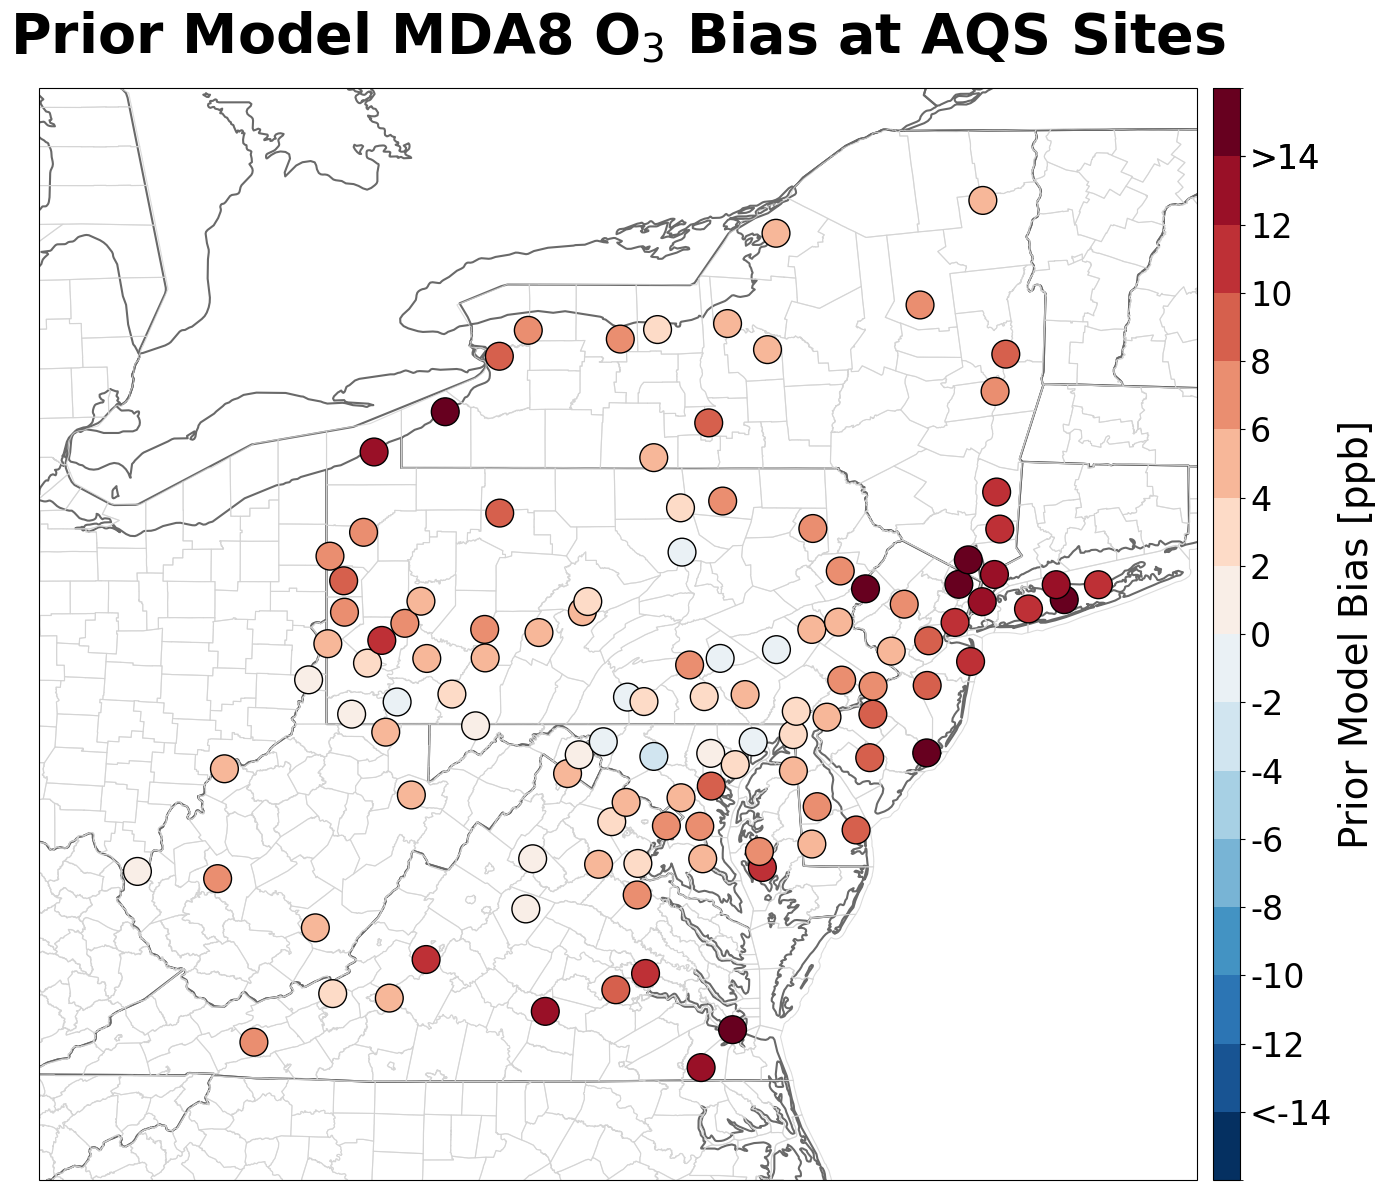

/home/jkumm/.local/lib/python3.9/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.


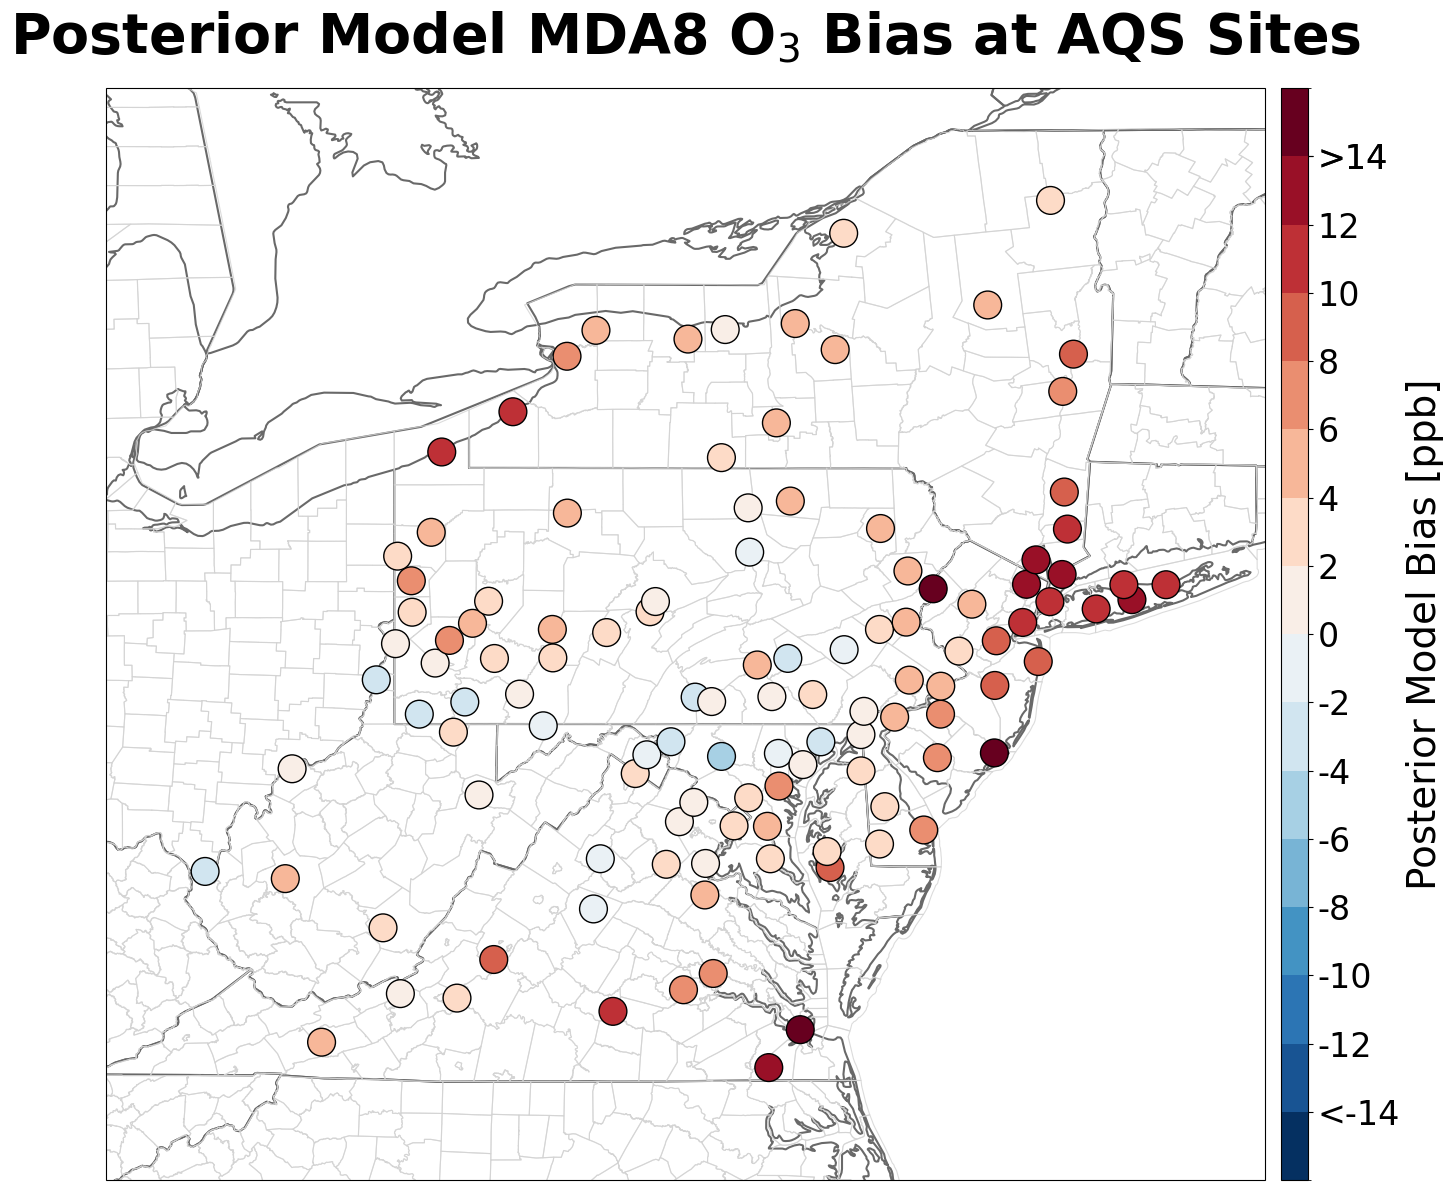

In [21]:
def plot_bias_map(
    df,
    counties_shapefile_path,
    region_extent=None,
    cmap='RdBu_r',
    title='Site Bias Map',
    use_posterior=False,
    save_label='northeast_prior'
):
    """
    Plot site locations colored by Bias on a map with state and county boundaries.
    Colorbar is centered at 0 and binned every 2 ppb from <-20 to >+20.
    Args:
        df: DataFrame with columns ['Lat', 'Lon', 'Bias2', 'Bias1']
        counties_shapefile_path: Path to US counties shapefile (.shp)
        region_extent: [lon_min, lon_max, lat_min, lat_max] or None for auto
        cmap: Colormap for Bias
        title: Plot title
        use_posterior: If True, plot Bias1 (Posterior Model); else Bias2 (Prior Model)
    """
    # Choose which bias to plot
    bias_col = 'Bias1' if use_posterior else 'Bias2'
    bias_label = 'Posterior Model' if use_posterior else 'Prior Model'

    # Define bins from -22 to 22 (so that <-20 and >20 are included), step 2
    bins = np.arange(-16, 18, 2)
    norm = BoundaryNorm(bins, ncolors=plt.get_cmap(cmap).N, clip=True)

    fig = plt.figure(figsize=(16, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set extent
    if region_extent:
        ax.set_extent(region_extent, crs=ccrs.PlateCarree())
    else:
        margin = 1
        ax.set_extent([
            df['Lon'].min()-margin, df['Lon'].max()+margin,
            df['Lat'].min()-margin, df['Lat'].max()+margin
        ], crs=ccrs.PlateCarree())

    # Add state boundaries
    ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='dimgray', linewidth=1.5, zorder=1)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='dimgray', linewidth=1.5, zorder=1)

    # Add all US counties
    counties = gpd.read_file(counties_shapefile_path)
    counties = counties.to_crs(epsg=4326)
    counties.boundary.plot(ax=ax, linewidth=0.8, edgecolor='lightgray', zorder=2, alpha=0.8)

    # Plot the sites
    sc = ax.scatter(
        df['Lon'], df['Lat'], c=df[bias_col], cmap=cmap, s=400, edgecolor='black',
        norm=norm, zorder=3
    )
    # Custom ticks/labels for colorbar
    cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.01, aspect=40, boundaries=bins, ticks=bins)
    cbar.set_label(f'{bias_label} Bias [ppb]', fontsize=28)
    cbar.ax.tick_params(labelsize=24)
    tick_labels = [f"<{bins[1]}"] + [str(int(b)) for b in bins[2:-1]] + [f">{bins[-2]}"]
    cbar.set_ticks([bins[1]] + list(bins[2:-1]) + [bins[-2]])
    cbar.set_ticklabels(tick_labels)

    ax.set_title(title, fontsize=40, weight='bold', pad=25)
    ax.set_xlabel('Longitude', fontsize=32, weight='bold')
    ax.set_ylabel('Latitude', fontsize=32, weight='bold')
    ax.tick_params(labelsize=26)
    plt.tight_layout()
    plt.savefig(f"./final_plots/{save_label}_bias.png", dpi=600, bbox_inches="tight", transparent=False)
    plt.show()

# Example usage:
plot_bias_map(bias_stats_ne, 'counties_shapefile/tl_2023_us_county.shp', title='Prior Model MDA8 O$_3$ Bias at AQS Sites', use_posterior=False, save_label='northeast_prior')
plot_bias_map(bias_stats_ne, 'counties_shapefile/tl_2023_us_county.shp', title='Posterior Model MDA8 O$_3$ Bias at AQS Sites', use_posterior=True, save_label='northeast_post')

/home/jkumm/.local/lib/python3.9/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.


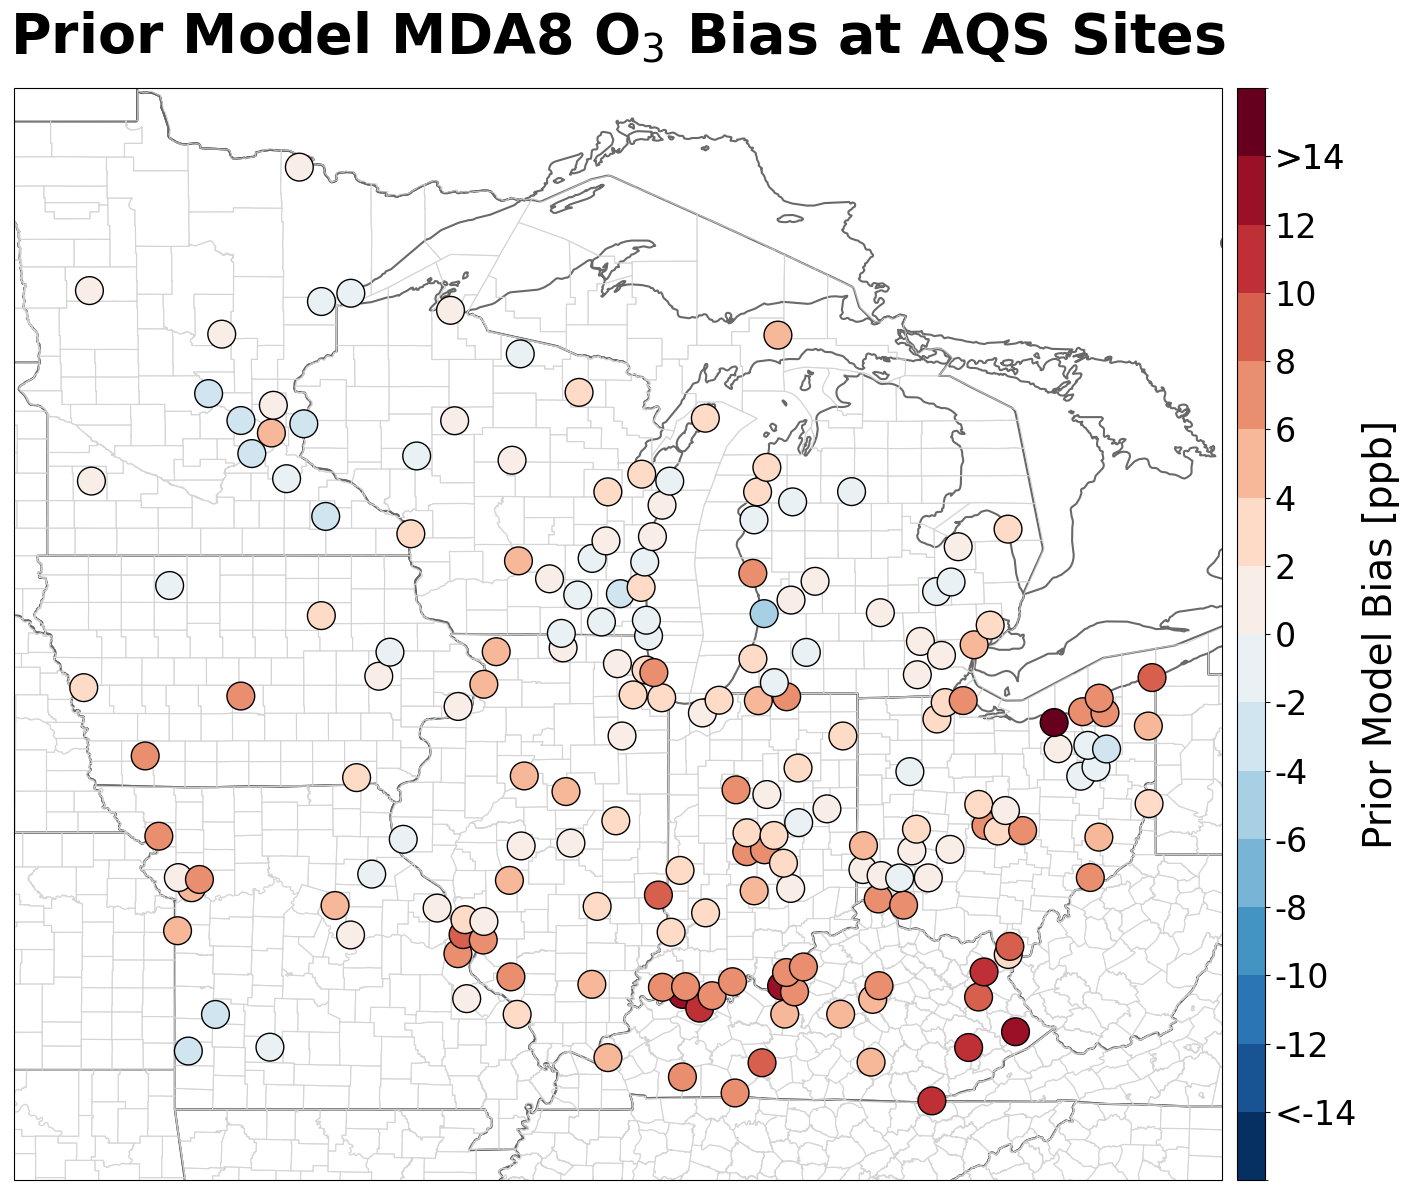

/home/jkumm/.local/lib/python3.9/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.


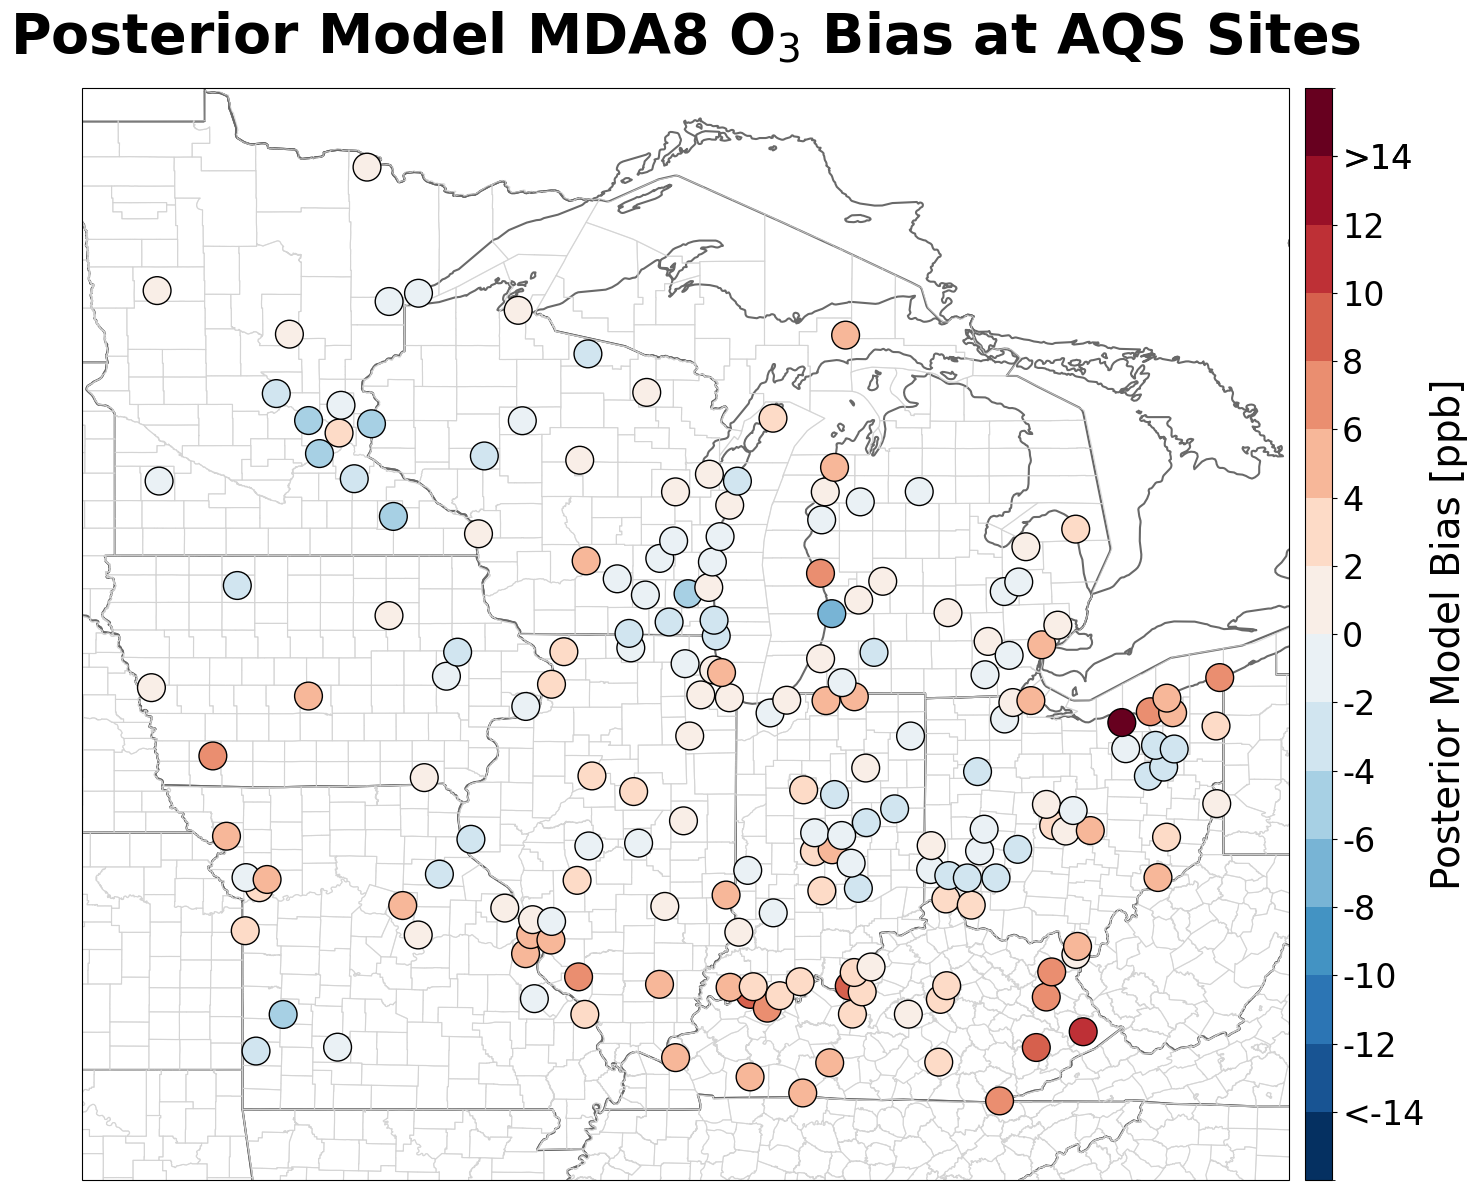

In [22]:
plot_bias_map(bias_stats_mw, 'counties_shapefile/tl_2023_us_county.shp', title='Prior Model MDA8 O$_3$ Bias at AQS Sites', use_posterior=False, save_label='midwest_prior')
plot_bias_map(bias_stats_mw, 'counties_shapefile/tl_2023_us_county.shp', title='Posterior Model MDA8 O$_3$ Bias at AQS Sites', use_posterior=True, save_label='midwest_post')

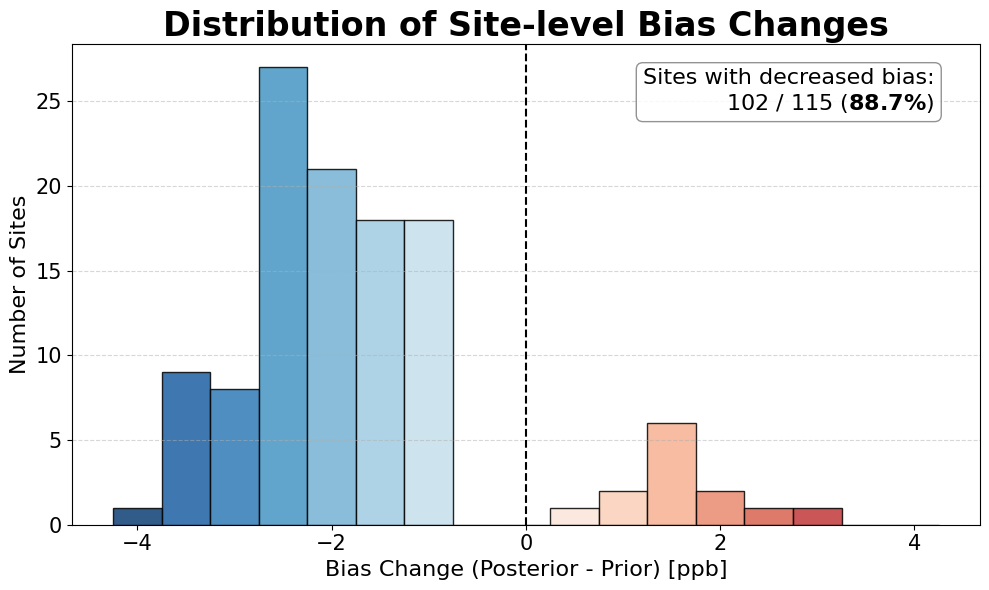

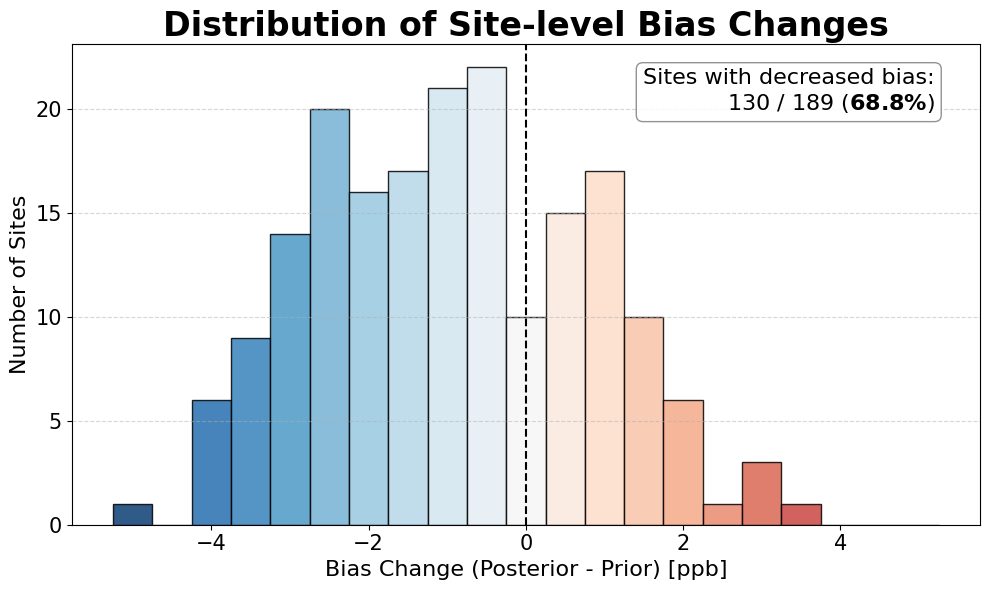

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

def plot_bias_diff_histogram(df, region_label="Northeast"):
    """
    Plot histogram of Bias_Diff with annotation for % of sites with decreased bias.
    Bars are colored using the RdBu_r color scale.
    """
    bias_diff = df['Bias_Diff'].dropna()
    max_abs = np.ceil(np.abs(bias_diff).max())

    bins = np.arange(-max_abs-0.25, max_abs+0.75, 0.5)
    n_sites = len(bias_diff)
    n_decreased = (bias_diff < 0).sum()
    pct_decreased = 100 * n_decreased / n_sites

    # Compute histogram
    counts, bin_edges = np.histogram(bias_diff, bins=bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Normalize bin centers for colormap
    norm = mpl.colors.Normalize(vmin=bins[0], vmax=bins[-1])
    cmap = plt.get_cmap('RdBu_r')
    colors = cmap(norm(bin_centers))

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(bin_centers, counts, width=0.5, color=colors, edgecolor='black', alpha=0.85)
    ax.axvline(0, color='k', linestyle='--', linewidth=1.5, label='No Change')

    # Text box with stats
    textstr = (
        f"Sites with decreased bias:\n"
        f"{n_decreased} / {n_sites} ($\mathbf{{{pct_decreased:.1f}\%}}$)"
    )
    ax.text(
        0.95, 0.95, textstr,
        transform=ax.transAxes,
        fontsize=16,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.85, edgecolor='gray')
    )

    ax.set_xlabel("Bias Change (Posterior - Prior) [ppb]", fontsize=16)
    ax.set_ylabel("Number of Sites", fontsize=16)
    ax.set_title(f"Distribution of Site-level Bias Changes", fontsize=24, weight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.tick_params(axis='both', labelsize=15)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_bias_diff_histogram(bias_stats_ne, region_label="Northeast")
plot_bias_diff_histogram(bias_stats_mw, region_label="Midwest")